In [1]:
from asap.util.io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
from asap.data.dataloader import DataSet
from asap.util import topics

import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc


experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sample_in = args.home + args.experiment + args.input+ args.sample_id +'/'+args.sample_id
sample_out = args.home + args.experiment + args.output+ args.sample_id +'/'+args.sample_id

dl = DataSet(sample_in,sample_out,data_mode='sparse',data_ondisk=False)
dl.config = args
print(dl.inpath)
print(dl.outpath)

from asap.data import sim

N=1000
P=2000
K=10

H = sim.generate_H(N, K)
W = sim.generate_W(P, K)
R = np.matmul(H, W.T) 
X = np.random.poisson(R)

dl.mtx = np.asmatrix(X)
dl.rows = ['c_'+str(i) for i in range(N) ]
dl.cols = ['g_'+str(i) for i in range(P) ]

/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/simdata/simdata
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/simdata/simdata


In [2]:
from asap.annotation import ASAPNMF
import asapc 

asap = ASAPNMF(adata=dl)
asap.get_pbulk()
asap.pbulk_mat.shape

(419, 2000)

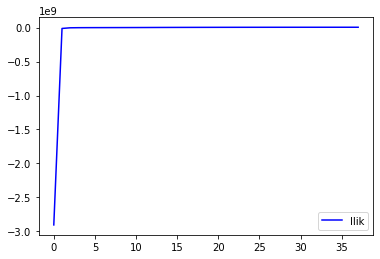

In [4]:
K = 10
nmf_model = asapc.ASAPdcNMF(asap.pbulk_mat.T,K)
nmf = nmf_model.nmf()

plt.plot(nmf.llik_trace,'b',label='llik')
plt.legend()

In [5]:
nmf.beta.shape

(2000, 10)

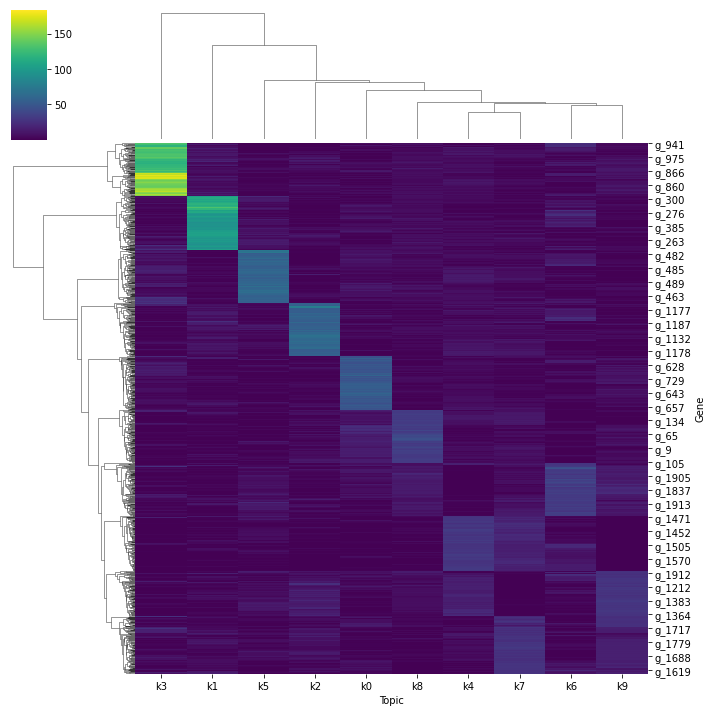

In [6]:
df_beta = pd.DataFrame(nmf.beta.T)

df_beta.columns = dl.cols
df_top = topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=100)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')

# df_top[df_top>100] = 100
sns.clustermap(df_top.T,cmap='viridis')

In [7]:
regm = asapc.ASAPdcNMFPredict(dl.mtx.T,nmf.beta_a,nmf.beta_b)
reg = regm.predict()

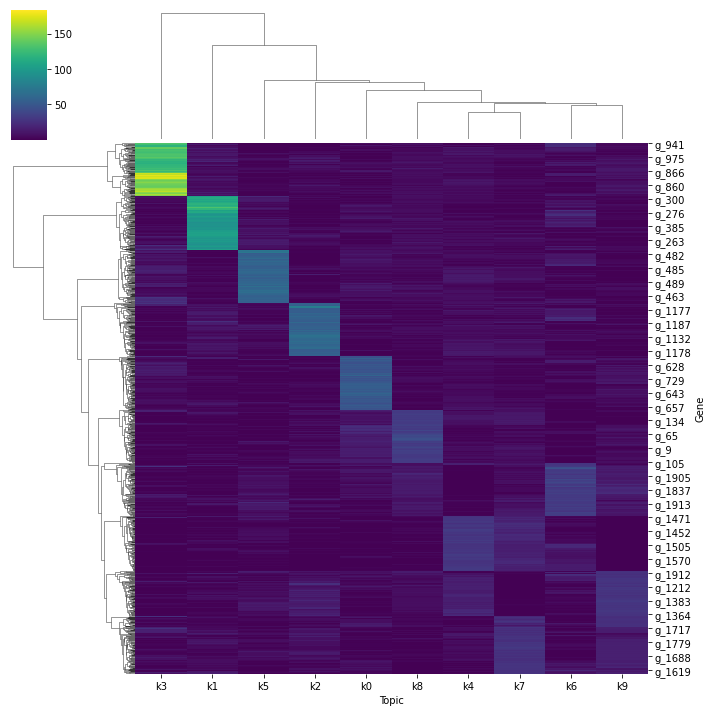

In [8]:
df_beta = pd.DataFrame(reg.beta.T)

df_beta.columns = dl.cols
df_top = topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=100)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')

# df_top[df_top>100] = 100
sns.clustermap(df_top.T,cmap='viridis')

In [9]:
import umap
df_theta = pd.DataFrame(reg.theta)
df_umap= pd.DataFrame()
df_umap['cell'] = dl.rows
df_umap['topic_bulk'] = [x for x in df_theta.iloc[:,:].idxmax(axis=1)]

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.0,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

,cell,topic_bulk,umap1,umap2
0,c_0,8,5.788022,8.243725
1,c_1,5,4.584360,5.972529
2,c_2,7,7.209592,6.376691
3,c_3,0,7.900852,3.074070
4,c_4,0,8.595356,4.249741
...,...,...,...,...
995,c_995,4,4.476034,8.572445
996,c_996,9,7.081302,2.571702
997,c_997,7,7.392690,2.035684
998,c_998,0,4.362361,4.614846


Text(0, 0.5, 'UMAP2')

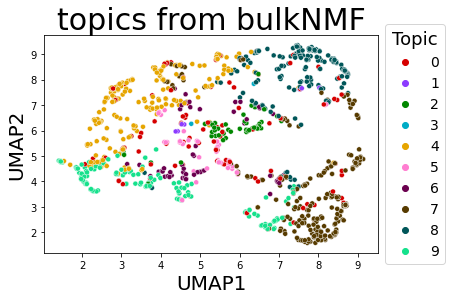

In [10]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_bulk'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_bulk',s=25,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

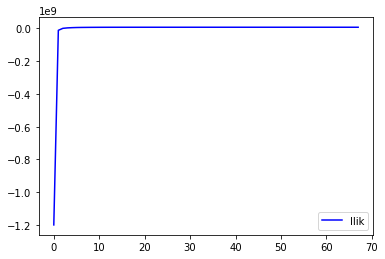

In [11]:
plt.plot(reg.llik_trace,'b',label='llik')
plt.legend()

In [ ]:
sns.heatmap(nmf.col_deg)

In [ ]:
sns.heatmap(reg.col_deg)

In [ ]:
asap.factorize()

In [ ]:
df_beta = pd.DataFrame(asap.model.Ebeta)
df_beta.columns = dl.cols
df_top = topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=100)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')

# df_top[df_top>100] = 100
sns.clustermap(df_top.T,cmap='viridis')

In [ ]:
asap.predict(dl.mtx)

In [ ]:
import umap
df_theta = pd.DataFrame( asap.model.predicted_params['theta_a']/asap.model.predicted_params['theta_b'])
df_umap= pd.DataFrame()
df_umap['cell'] = dl.rows
df_umap['topic_bulk'] = [x for x in df_theta.iloc[:,:].idxmax(axis=1)]

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.0,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

In [ ]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_bulk'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_bulk',s=25,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)